In [25]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, AdamW  
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/validation.csv")
test_df = pd.read_csv("../data/test.csv")

In [19]:
tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-mini')

def tokenize(data, max_length=87):
    return tokenizer(
        data["Comment_Adj"].tolist(),
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

class CommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)
test_encodings = tokenize(test_df)

train_dataset = CommentsDataset(train_encodings, train_df['Result_Bin'])
val_dataset = CommentsDataset(val_encodings, val_df['Result_Bin'])
test_dataset = CommentsDataset(test_encodings, test_df['Result_Bin'])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

In [20]:
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-mini', num_labels=2)
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

total_epochs = 6

for epoch in range(total_epochs):
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{total_epochs}") as pbar:
        for batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            pbar.set_postfix(loss=f"{loss.item():.4f}")

print("Training completed.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jackiecollopy/nlp-virtual/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/6:   0%|                                                              | 0/683 [00:00<?, ?batch/s]/var/folders/hs/br_4rpdj68nc3sfdpgv0xgn80000gn/T/ipykernel_12767/33828928.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceT

Training completed.


In [32]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(batch['labels'].tolist())

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
print("Precision on Test:", round(precision,3))
print("Recall on Test:", round(recall,3))
print("F1 Score on Test:", round(f1,3))

/var/folders/hs/br_4rpdj68nc3sfdpgv0xgn80000gn/T/ipykernel_12767/33828928.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Precision on Test: 0.685
Recall on Test: 0.637
F1 Score on Test: 0.66


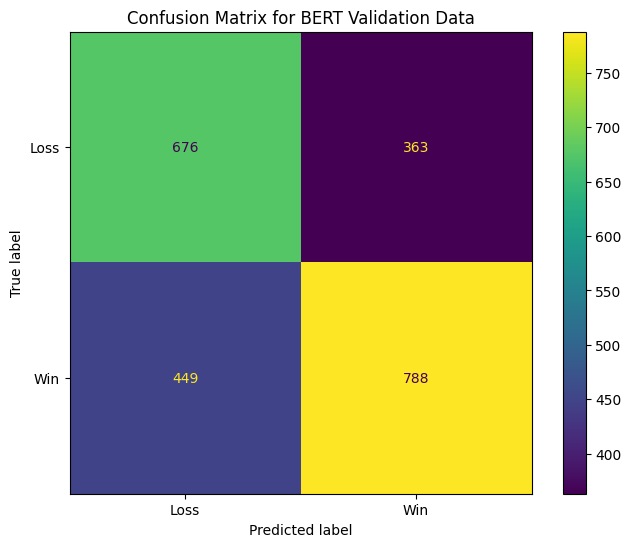

In [33]:
conf_matrix = confusion_matrix(true_labels, predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["Loss","Win"])
fig, ax = plt.subplots(figsize=(8, 6))  # You can specify the size of the figure here
cm_display.plot(ax=ax)

ax.set_title("Confusion Matrix for BERT Validation Data")

plt.savefig("bertv_confusion_matrix.pdf", format='pdf')

plt.show()

In [ ]:
model.save_pretrained('./bert.pth')

In [34]:
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=-1).tolist())
        true_labels.extend(batch['labels'].tolist())

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
print("Precision on Test:", round(precision,3))
print("Recall on Test:", round(recall,3))
print("F1 Score on Test:", round(f1,3))

/var/folders/hs/br_4rpdj68nc3sfdpgv0xgn80000gn/T/ipykernel_12767/33828928.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Precision on Test: 0.674
Recall on Test: 0.633
F1 Score on Test: 0.653


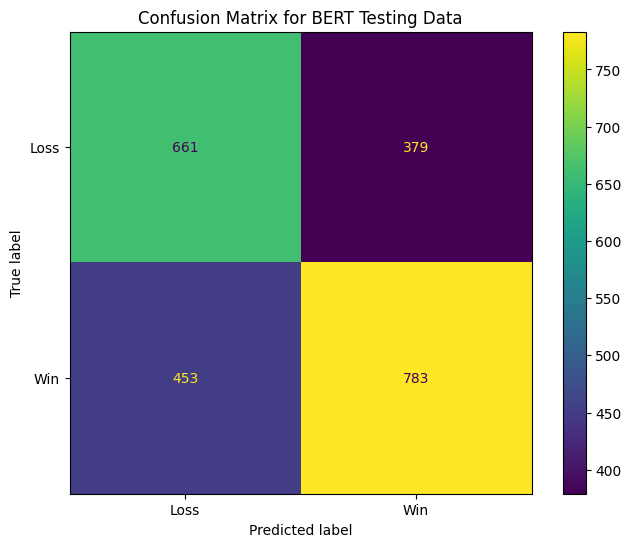

In [35]:
conf_matrix = confusion_matrix(true_labels, predictions)

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = ["Loss","Win"])
fig, ax = plt.subplots(figsize=(8, 6))  # You can specify the size of the figure here
cm_display.plot(ax=ax)

ax.set_title("Confusion Matrix for BERT Testing Data")

plt.savefig("bertt_confusion_matrix.pdf", format='pdf')

plt.show()

In [ ]:
results_df = test_df.copy()
results_df["Predicted"]